# Rossmann Store Sales - Final Project at Statistical Monitoring and Anomaly Detection
## Group 7

Almog Asraf

Daniel Pidtylok

Nir Levanon

Imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from sklearn.cluster import KMeans
import statistics
from fitter import Fitter, get_common_distributions, get_distributions
import hvplot
import hvplot.pandas
from sklearn.manifold import TSNE

Loading files into pandas dataframe:

In [2]:
path = "./rossmann-store-sales/"
store = pd.read_csv(f"{path}store.csv", encoding="utf8")
train = pd.read_csv(f"{path}train.csv", encoding="utf8")
# test = pd.read_csv(f"{path}test.csv", encoding="utf8")

C:\Users\yumi4\AppData\Local\Temp\ipykernel_32948\1146988513.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(f"{path}train.csv", encoding="utf8")


In [3]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [4]:
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
#test.head()

### Datasert Discription
We are provided with historical sales data for 1,115 Rossmann stores. Note that some stores in the dataset were temporarily closed for refurbishment.

#### Files
* train.csv - historical data including Sales
* test.csv - historical data excluding Sales
* sample_submission.csv - a sample submission file in the correct format
* store.csv - supplemental information about the stores
#### Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Dataset Exploration

#### Calculate summary statictics:

In [6]:
store.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

In [7]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
#test.describe()

In [9]:
train.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


#### Visualization

C:\Users\yumi4\AppData\Local\Temp\ipykernel_32948\1865675925.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Sales'],bins=100)


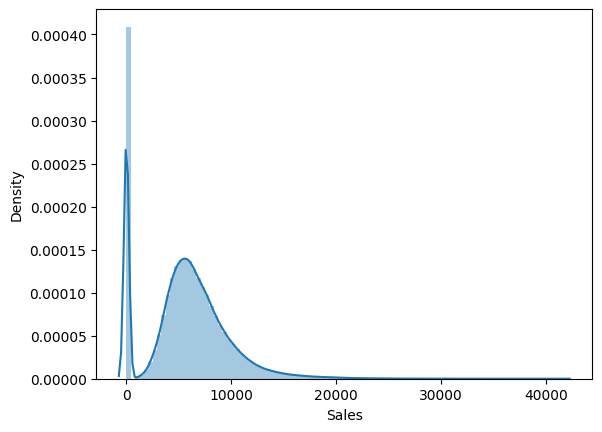

In [11]:
# visualize the distribution of sales
sns.distplot(train['Sales'],bins=100)
plt.show()

C:\Users\yumi4\AppData\Local\Temp\ipykernel_32948\159293706.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Customers'],bins=100)


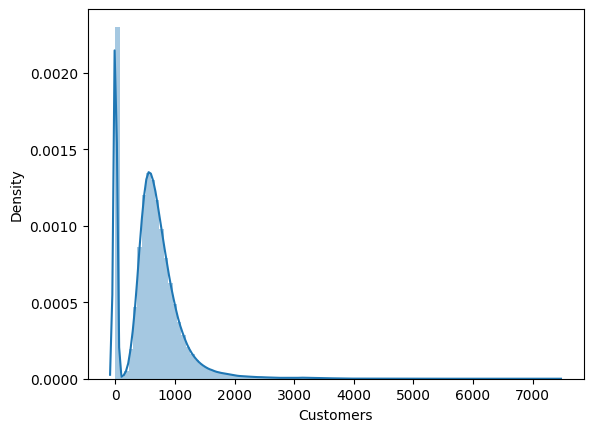

In [12]:
# visualize the distribution of customers
sns.distplot(train['Customers'],bins=100)
plt.show()

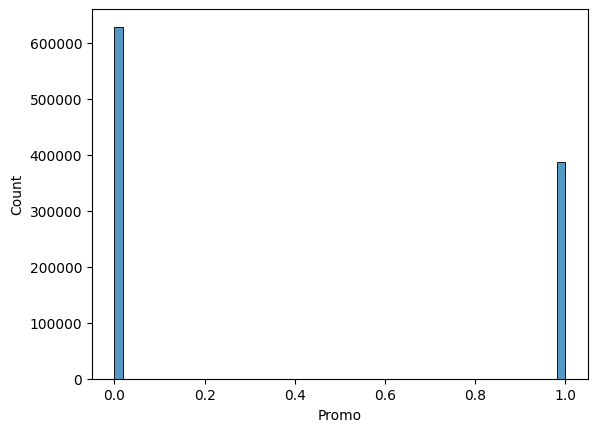

In [13]:
# visualize the distribution of promo
sns.histplot(train['Promo'])
plt.show()

We can see that promo is a binary variable.

#### Exploration of the relationships between variables

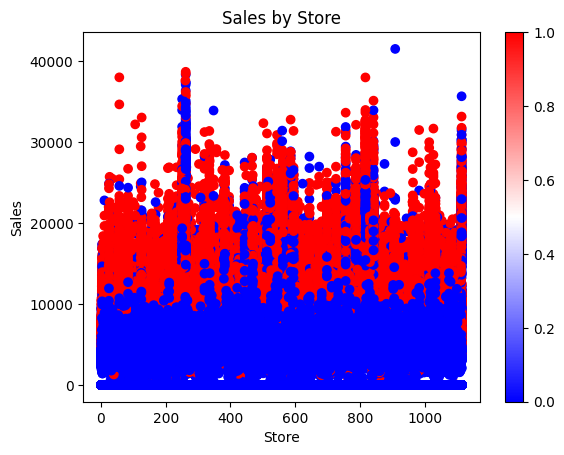

In [14]:
# explore relationships between promo and sales
# sns.scatterplot(x='Promo', y='Sales', data=train)
# plt.show()

plt.scatter(train['Store'], train['Sales'], c=train['Promo'], cmap='bwr')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.title('Sales by Store')
plt.colorbar()
plt.show()


We can see that it is more likley that there was no sales when there was no promo, but there are anomalies (i.e. more than 40000 sales with no promo).

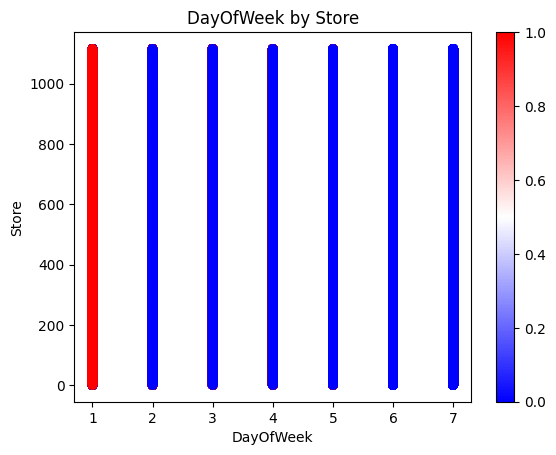

In [15]:
# explore relationships between promo and sales
# sns.scatterplot(x='Promo', y='DayOfWeek', data=train)
# plt.show()
plt.scatter(train['DayOfWeek'],train['Store'], c=train['Promo'], cmap='bwr')
plt.xlabel('DayOfWeek')
plt.ylabel('Store')
plt.title('DayOfWeek by Store')
plt.colorbar()
plt.show()

We can see that there are no promos on Sunday.

Check for missing values:

In [16]:
print(train.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [17]:
#print(test.isnull().sum())

In [18]:
print(store.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


In [19]:
train['Date'] = pd.to_datetime(train['Date'])
train['Open'] = train['Open'].astype(bool)
train['Promo'] = train['Promo'].astype(bool)
train['SchoolHoliday'] = train['SchoolHoliday'].astype(bool)
print(train['StateHoliday'].unique())
train['StateHoliday'] = train['StateHoliday'].replace({0:'0'})
print(train['StateHoliday'].unique())
train.head()

['0' 'a' 'b' 'c' 0]
['0' 'a' 'b' 'c']


Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555  True   True            0   
1      2          5 2015-07-31   6064        625  True   True            0   
2      3          5 2015-07-31   8314        821  True   True            0   
3      4          5 2015-07-31  13995       1498  True   True            0   
4      5          5 2015-07-31   4822        559  True   True            0   

   SchoolHoliday  
0           True  
1           True  
2           True  
3           True  
4           True

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  bool          
 6   Promo          1017209 non-null  bool          
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  bool          
dtypes: bool(3), datetime64[ns](1), int64(4), object(1)
memory usage: 49.5+ MB


In [21]:
# test['Date'] = pd.to_datetime(test['Date'])
# test['Open'] = test['Open'].astype(bool)
# test['Promo'] = test['Promo'].astype(bool)
# test['SchoolHoliday'] = test['SchoolHoliday'].astype(bool)
# print(test['StateHoliday'].unique())
# test.head()

In [22]:
store['Promo2'] = store['Promo2'].astype(bool)
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   bool   
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: bool(1), float64(5), int64(1), object(3)
memory usage: 79.6+ KB


We choose not to replace NaN values because it makes sense and it will be easier for us later to use it.

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


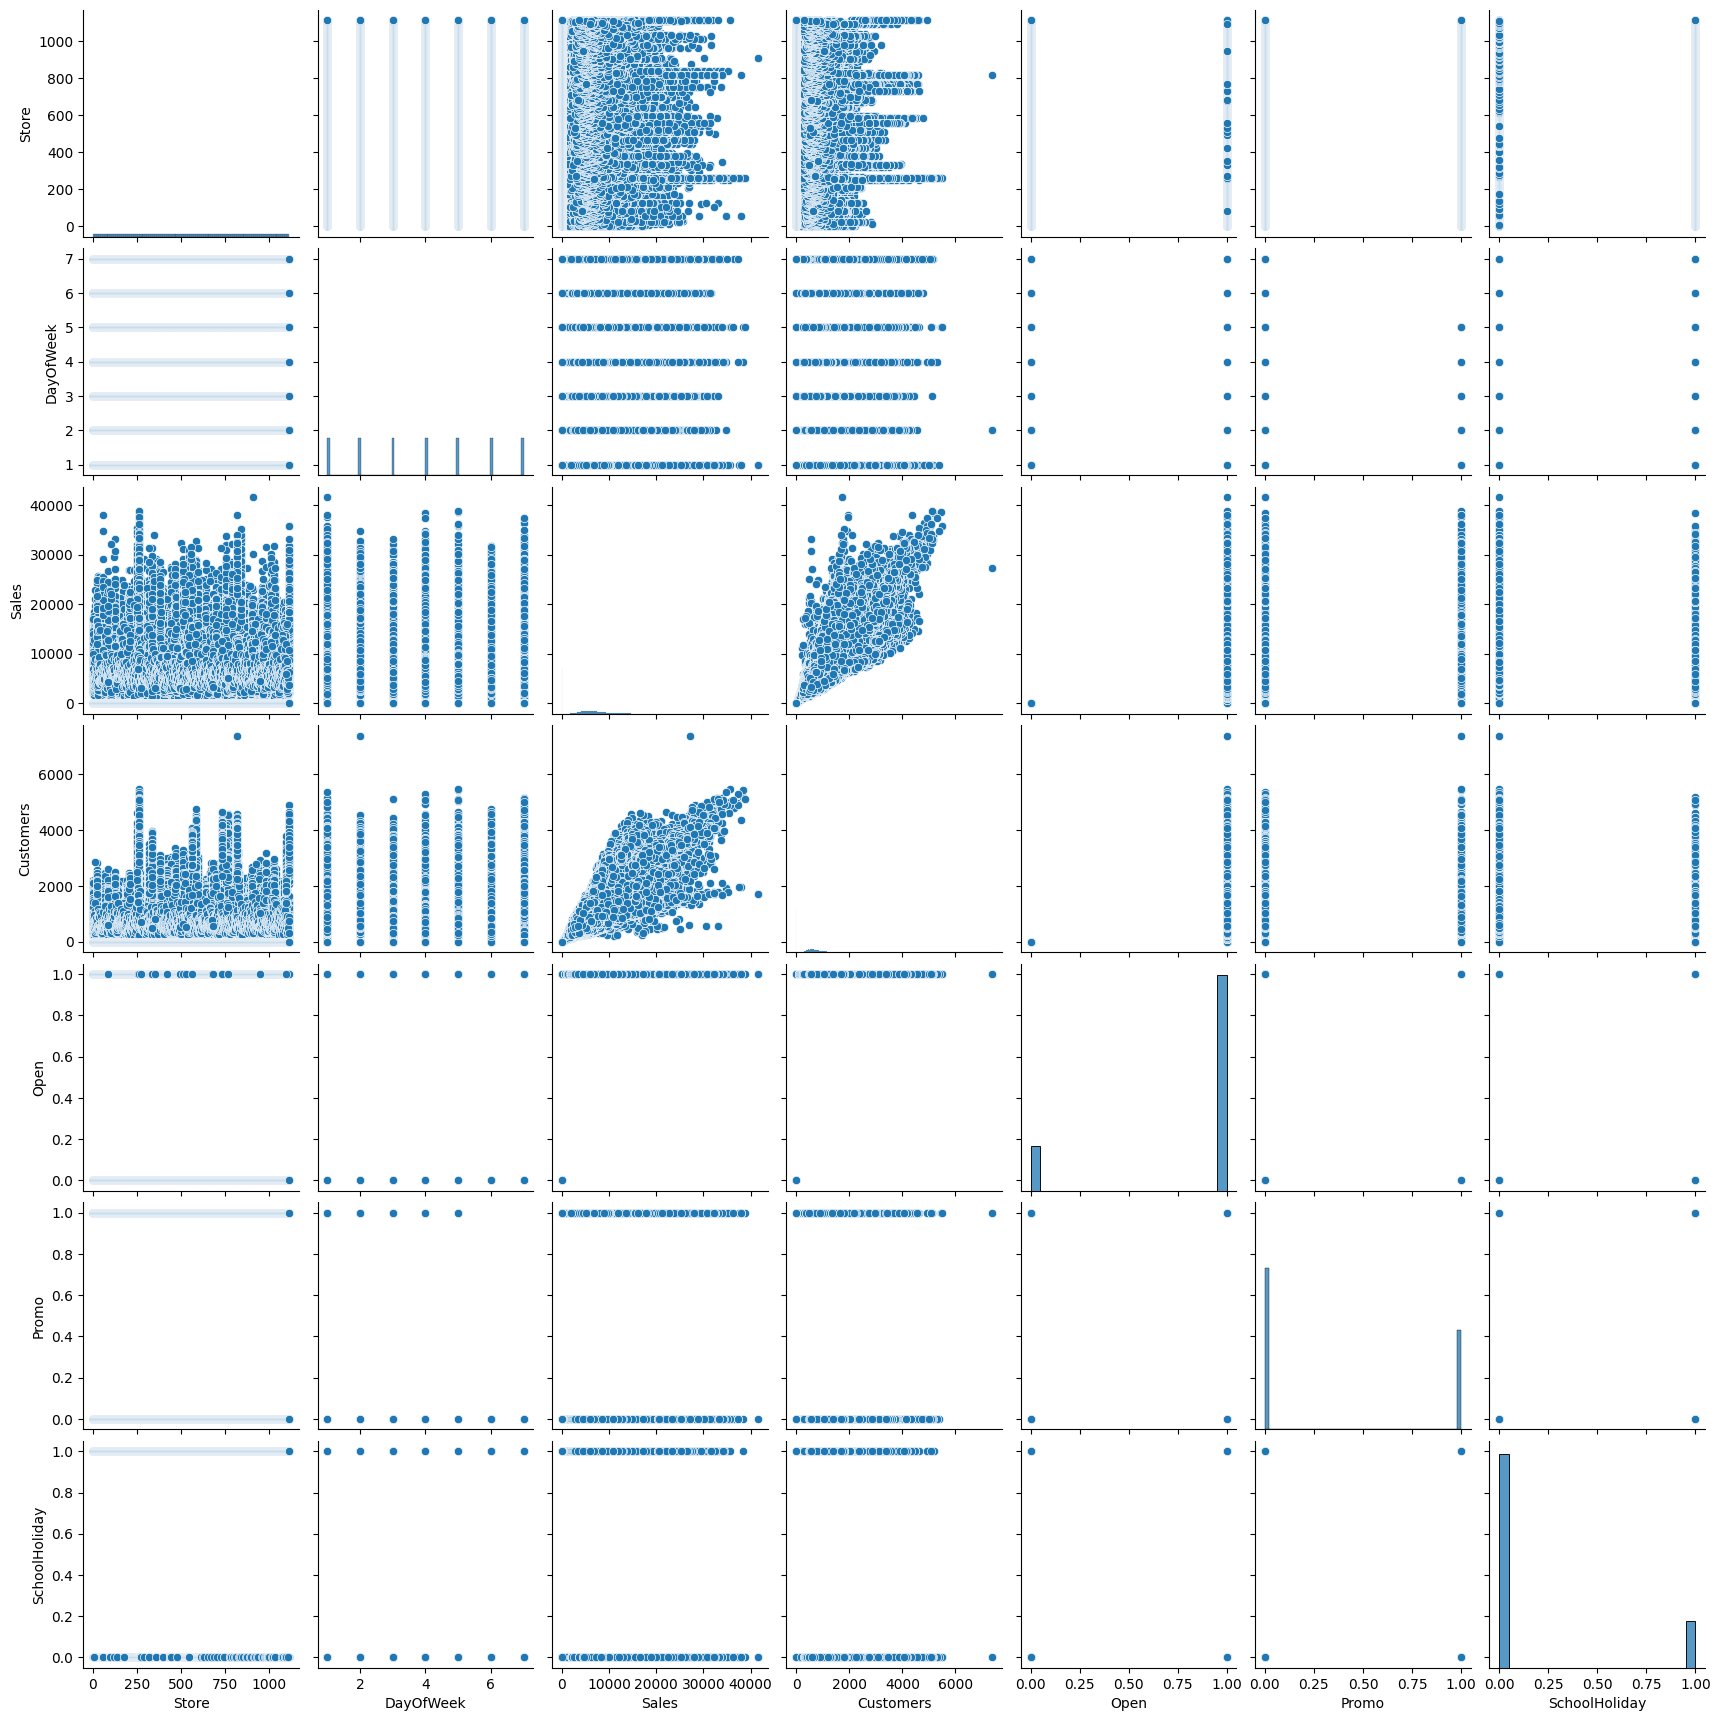

In [23]:
sns.pairplot(train)

In [24]:
train.corr().style.background_gradient(cmap="GnBu")

C:\Users\yumi4\AppData\Local\Temp\ipykernel_32948\2052744557.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr().style.background_gradient(cmap="GnBu")


We can see there is high correlation between customers and sales, which makes sense, so we will drop 'Customers' column.

In [25]:
train = train.drop(columns=['Customers'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Open           1017209 non-null  bool          
 5   Promo          1017209 non-null  bool          
 6   StateHoliday   1017209 non-null  object        
 7   SchoolHoliday  1017209 non-null  bool          
dtypes: bool(3), datetime64[ns](1), int64(3), object(1)
memory usage: 41.7+ MB


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


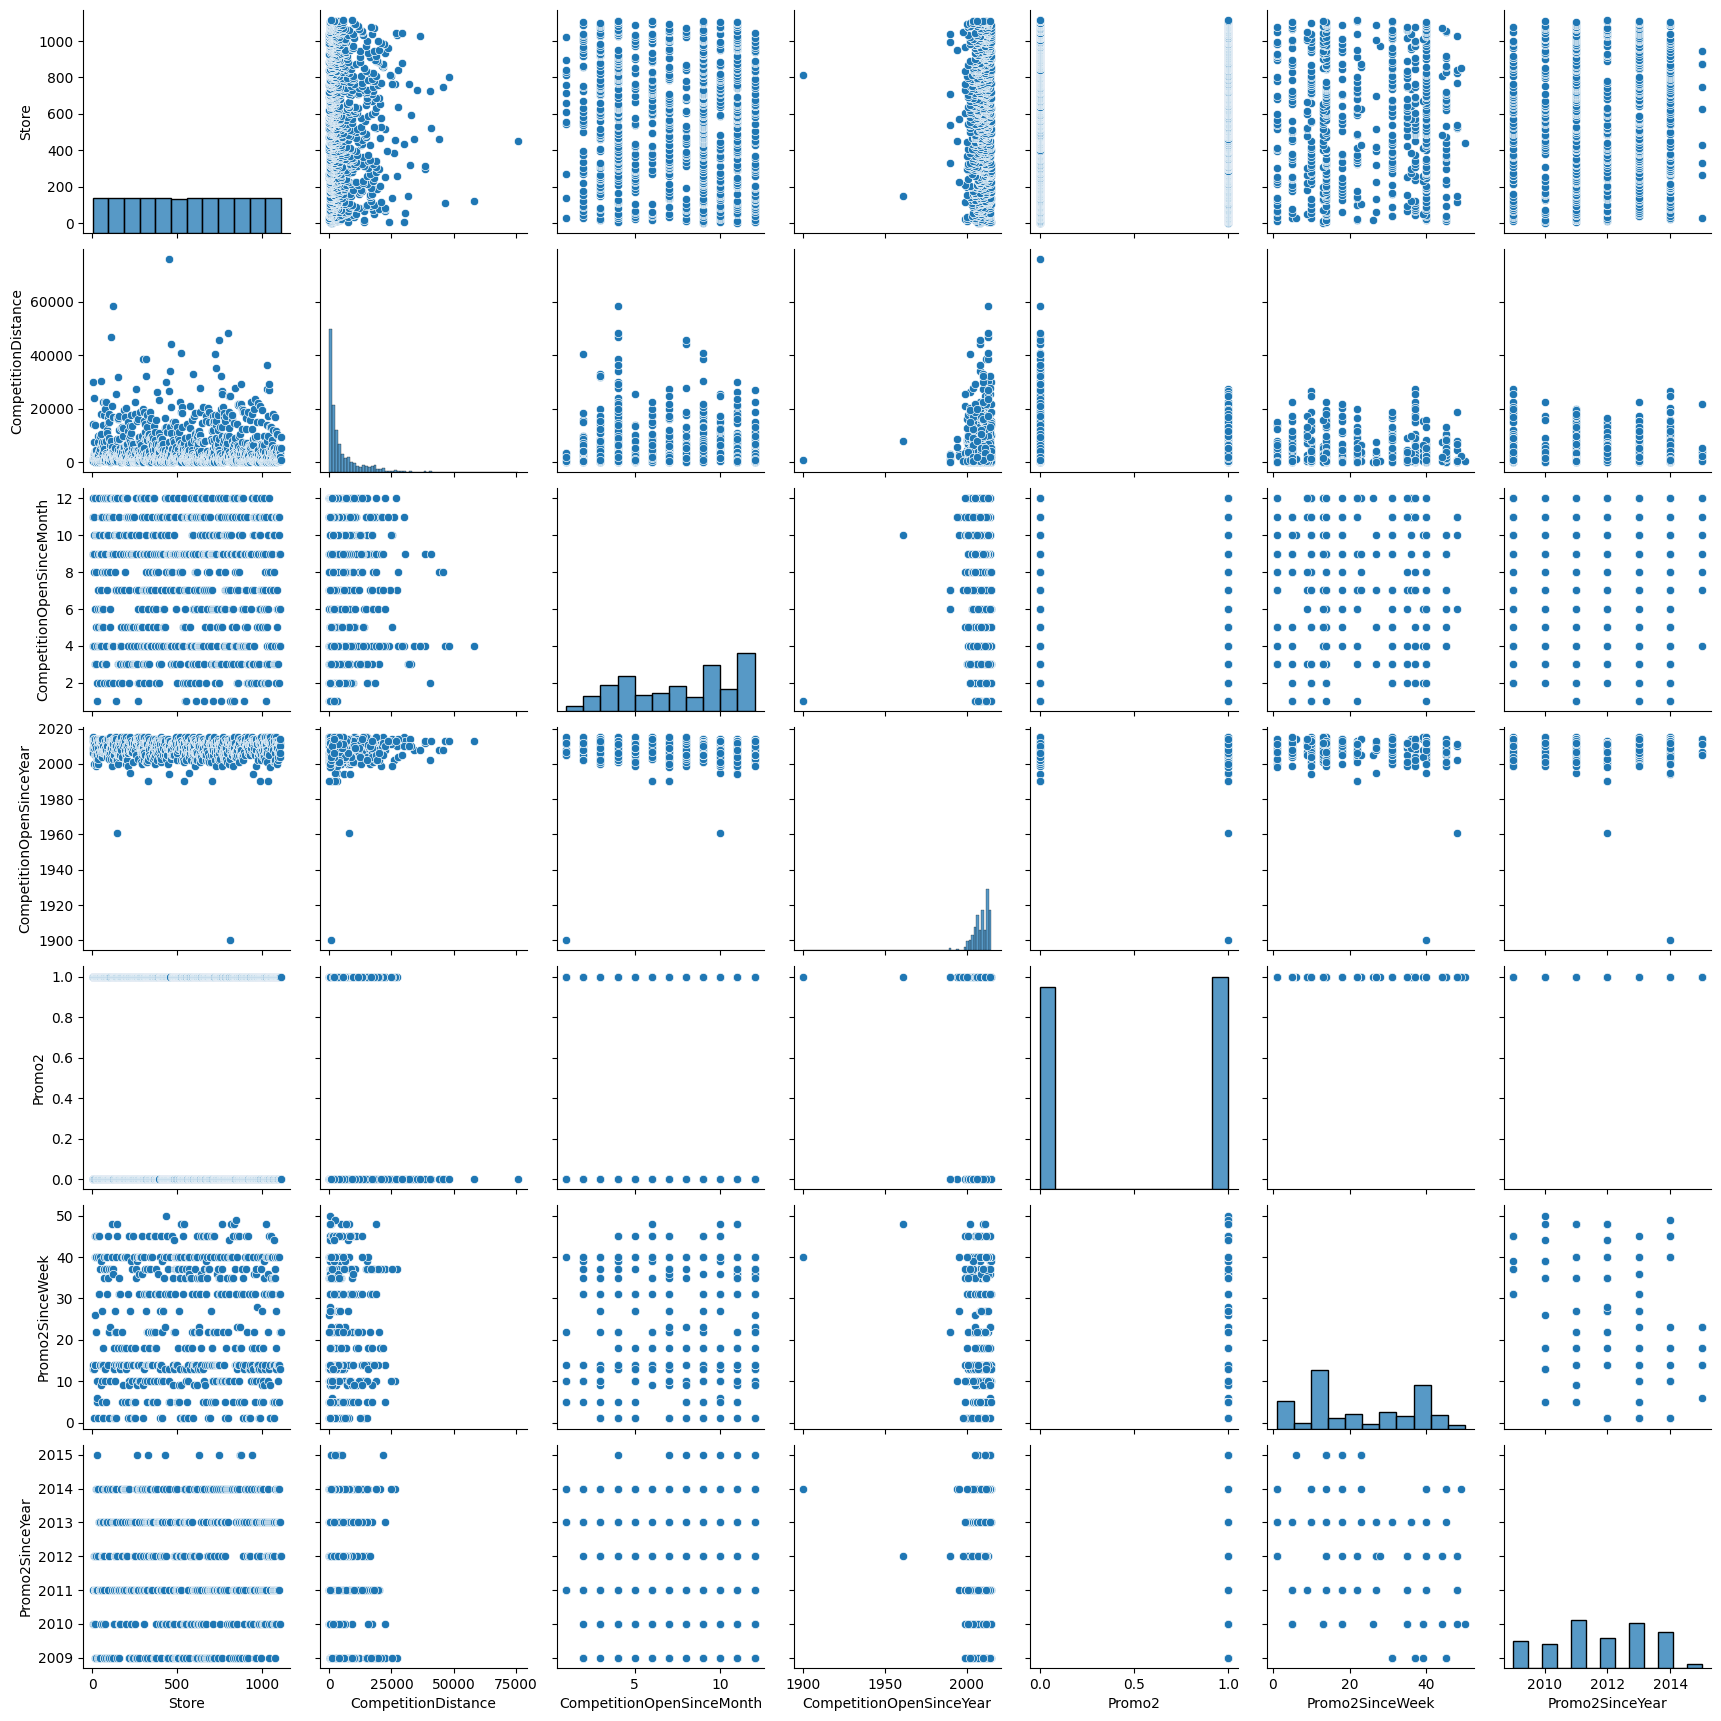

In [26]:
sns.pairplot(store)

## SPC

First, we want to understand the sales distribution:

Fitting 5 distributions:  60%|██████    | 3/5 [00:30<00:22, 11.02s/it]SKIPPED beta distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
Fitting 5 distributions: 100%|██████████| 5/5 [00:30<00:00,  6.01s/it]
lognorm was not fitted. no parameters available
beta was not fitted. no parameters available
burr was not fitted. no parameters available


sumsquare_error          aic           bic  kl_div  ks_statistic  \
norm        1.610119e-07  4327.897729 -2.998156e+07     inf      0.103103   
gamma       1.667522e-07  3157.680725 -2.994591e+07     inf      0.122911   
lognorm              inf          inf           inf     inf           NaN   
beta                 inf          inf           inf     inf           NaN   
burr                 inf          inf           inf     inf           NaN   

         ks_pvalue  
norm           0.0  
gamma          0.0  
lognorm        NaN  
beta           NaN  
burr           NaN

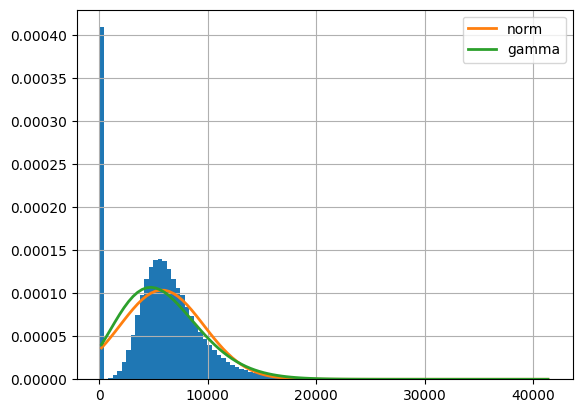

In [27]:
sales = train['Sales'].values
f = Fitter(sales,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [28]:
f.get_best(method = 'sumsquare_error')

{'norm': {'loc': 5773.818972305593, 'scale': 3849.924282837465}}

We can see that sales are coming from normal distirbution. We will use this for buliding UCL and LCL.

In [29]:
# sample data for store sales
sales_samples = train[['Store', 'Sales']].sample(n=100)
# sales_samples = sales_samples.sort_values(by='Store')
# sales_samples = sales_samples.groupby('Store')['Sales'].agg(lambda x: x.tolist()).reset_index()
sales_samples

Store  Sales
130622    168      0
970762    383  14371
842880    726   8125
667468    369      0
444426    327      0
...       ...    ...
765617    398   5960
737878    534      0
963332    758   7617
615239    545   9473
98262     143   9514

[100 rows x 2 columns]

In [30]:
len(train)

1017209

In [31]:
np.random.seed(42)
samples = pd.DataFrame(columns=['store','sales','sample_group'])
for i in range(10):
    # sample data for store sales
    sales_samples = train[['Store', 'Sales']].sample(n=100)
    # calculate the mean and standard deviation of the data
    mean = np.mean(sales_samples)
    std_dev = np.std(sales_samples)
    to_samples = {'store':sales_samples['Store'],'sales':sales_samples['Sales'],'sample_group':np.repeat(i,len(sales_samples))}
    to_samples = pd.DataFrame(to_samples)
    # print(to_samples.head())
    samples = pd.concat([samples,to_samples])
    # print(samples)
samples

c:\Users\yumi4\OneDrive\מסמכים\rossmann-store-sales\venv\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\yumi4\OneDrive\מסמכים\rossmann-store-sales\venv\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
c:\Users\yumi4\OneDrive\מסמכים\rossmann-store-sales\venv\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.

store  sales sample_group
76435    616      0            0
923026   592   5548            0
731180   526   7467            0
790350   601   3360            0
252134   953  11414            0
...      ...    ...          ...
655172   338   6662            9
143120   401   6752            9
836252   788  15519            9
577158   374   6312            9
249383  1014  20589            9

[1000 rows x 3 columns]

In [32]:
# Group masures by sample groups (x_bar)
samples_grouped = samples[['sales','sample_group']].groupby('sample_group').mean()
# Rename x-bar column
samples_grouped.columns = ['x_bar']
samples_grouped

x_bar
sample_group         
0             6072.03
1             5548.06
2             5722.21
3             5184.36
4             5199.84
5             6556.50
6             5864.08
7             6017.39
8             5610.87
9             6184.19

In [33]:
# Add R (range) column
samples_max = samples[['sales','sample_group']].groupby('sample_group').max()
samples_min = samples[['sales','sample_group']].groupby('sample_group').min()
samples_grouped['R'] = samples_max['sales'] - samples_min['sales']
samples_grouped

x_bar      R
sample_group                
0             6072.03  21956
1             5548.06  20596
2             5722.21  13777
3             5184.36  15114
4             5199.84  18438
5             6556.50  23093
6             5864.08  12915
7             6017.39  24908
8             5610.87  19078
9             6184.19  20589

In [34]:
# Get control limits
samples_grouped['x_bar_bar'] = statistics.mean(samples_grouped['x_bar'])
samples_grouped['UCL'] = statistics.mean(samples_grouped['x_bar'])+(0.577*statistics.mean(samples_grouped['R']))
samples_grouped['+2s'] =(samples_grouped['UCL']-samples_grouped['x_bar_bar'])/3*2+samples_grouped['x_bar_bar']
samples_grouped['+1s'] =(samples_grouped['UCL']-samples_grouped['x_bar_bar'])/3*1+samples_grouped['x_bar_bar']
samples_grouped['-1s'] = samples_grouped['x_bar_bar']-(samples_grouped['UCL']-samples_grouped['x_bar_bar'])/3*1
samples_grouped['-2s'] = samples_grouped['x_bar_bar']- (samples_grouped['UCL']-samples_grouped['x_bar_bar'])/3*2
samples_grouped['LCL'] = statistics.mean(samples_grouped['x_bar'])-(0.577*statistics.mean(samples_grouped['R']))
samples_grouped

x_bar      R  x_bar_bar         UCL         +2s        +1s  \
sample_group                                                                 
0             6072.03  21956   5795.953  16785.7258  13122.4682  9459.2106   
1             5548.06  20596   5795.953  16785.7258  13122.4682  9459.2106   
2             5722.21  13777   5795.953  16785.7258  13122.4682  9459.2106   
3             5184.36  15114   5795.953  16785.7258  13122.4682  9459.2106   
4             5199.84  18438   5795.953  16785.7258  13122.4682  9459.2106   
5             6556.50  23093   5795.953  16785.7258  13122.4682  9459.2106   
6             5864.08  12915   5795.953  16785.7258  13122.4682  9459.2106   
7             6017.39  24908   5795.953  16785.7258  13122.4682  9459.2106   
8             5610.87  19078   5795.953  16785.7258  13122.4682  9459.2106   
9             6184.19  20589   5795.953  16785.7258  13122.4682  9459.2106   

                    -1s        -2s        LCL  
sample_group                                   
0             2132.6954 -1530.5622 -5193.8198  
1             2132.6954 -1530.5622 -5193.8198  
2             2132.6954 -1530.5622 -5193.8198  
3             2132.6954 -1530.5622 -5193.8198  
4             2132.6954 -1530.5622 -5193.8198  
5             2132.6954 -1530.5622 -5193.8198  
6             2132.6954 -1530.5622 -5193.8198  
7             2132.6954 -1530.5622 -5193.8198  
8             2132.6954 -1530.5622 -5193.8198  
9             2132.6954 -1530.5622 -5193.8198

In [35]:
# Plot x-bar control chart

# Line chart
line_plot = samples_grouped.hvplot.line(
                            x='sample_group',
                            y=['x_bar','UCL','+2s','+1s','x_bar_bar','-1s','-2s','LCL'],
                            xlabel="Sample Group",
                            title="x-bar chart",
                            height=500,
                            width=1000)

# Scatter plot
scatter_plot = samples_grouped.hvplot.scatter(
                            x='sample_group',
                            y=['x_bar','UCL','+2s','+1s','x_bar_bar','-1s','-2s','LCL'],
                            xlabel="Sample Group",
                            title="x-bar chart",
                            height=500,
                            width=1000)

# Merge line chart and scatter plot into a single plot
x_bar_chart = line_plot*scatter_plot
x_bar_chart

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [sample_group]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Scatter   [sample_group]   (value)

In [36]:
# TODO: Calculate power (1-beta) of this control charts

## K Means Clustering

c:\Users\yumi4\OneDrive\מסמכים\rossmann-store-sales\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


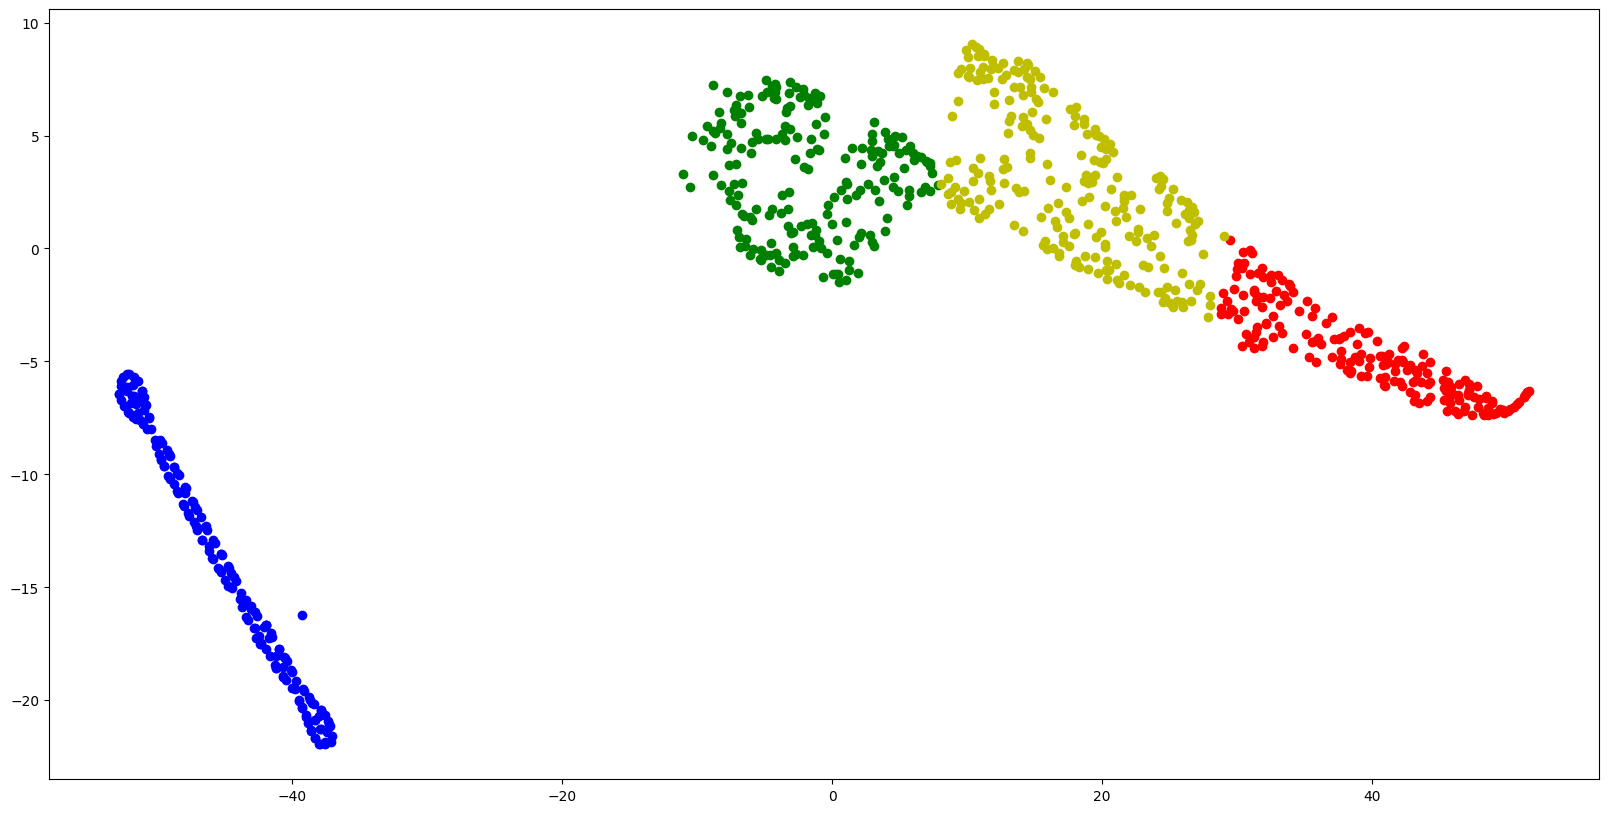

In [37]:
tsne = TSNE(n_components=2, perplexity=50)
components_TSNE = tsne.fit_transform(samples.values)
np.random.seed(42)
kmeans = KMeans(n_clusters=5).fit(components_TSNE)
fig, ax = plt.subplots(figsize=(20, 10))

plt.scatter(components_TSNE[kmeans.labels_==0][:,0],
            components_TSNE[kmeans.labels_==0][:,1], 
            c='r',)
plt.scatter(components_TSNE[kmeans.labels_==1][:,0],
            components_TSNE[kmeans.labels_==1][:,1], 
            c='b')
plt.scatter(components_TSNE[kmeans.labels_==2][:,0],
            components_TSNE[kmeans.labels_==2][:,1], 
            c='g')
plt.scatter(components_TSNE[kmeans.labels_==3][:,0],
            components_TSNE[kmeans.labels_==3][:,1], 
            c='y')